# Data Preprocessing and Exploration

* [Pull in Images from S3](#load-images)
* [Display Images With and Without Masks](#display-images)
* [More EDA and Preprocessing](#eda-preprocess)




The following notebooks demonstrates data loading, preprocessing, and EDA for dental x-rays, teeth masks, and abnormality masks. This is all done in advance of training a model that can predict teeth and abnormality locations in dental x-rays.

<a name="load-images"></a>
## Pull in Images from S3

In [ ]:
!pip install cloudpathlib
!pip install boto3
!pip install pillow
!pip install opencv-python

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
from cloudpathlib import CloudPath
from cloudpathlib import S3Client
from cloudpathlib import S3Path
import matplotlib.pyplot as plt
import boto3
import glob
import random
import re
import PIL
import keras
from sklearn.model_selection import train_test_split

In [ ]:
# Set environment variables
key_data = pd.read_csv('rootkey.csv')
#os.environ['AWS_ACCESS_KEY'] = ''
#os.environ['AWS_SECRET_KEY'] = ''

In [ ]:
# Create files in local storage for x-ray data after pulling from Amazon S3 bucket

def gatherS3Data(s3_path, folder_name):
  s3_client = S3Client(aws_access_key_id=os.getenv('AWS_ACCESS_KEY'), aws_secret_access_key=os.getenv('AWS_SECRET_KEY'))
  x_rays_images = s3_client.CloudPath(s3_path)
  x_rays_images.download_to(folder_name)

gatherS3Data('s3://ads-599-capstone-data/ads-599-team7/mask/', 'abnormality_masks')
gatherS3Data('s3://ads-599-capstone-data/ads-599-team7/Radiographs/', 'original_images')
gatherS3Data('s3://ads-599-capstone-data/ads-599-team7/teeth_mask/', 'teeth_masks')

<a name="display-images"></a>
## Display Images with and Without Masks (EDA)

In [ ]:
# Make a list of all original image files
def image_to_plot(images, cmap):
  file_list = images
  image_list = [plt.imread(i) for i in file_list]
  # Display 4 original x_ray images in grayscale
  fig, axes = plt.subplots(2, 2, figsize=(12, 8))
  k=0
  for i in range(2):
    for j in range(2):
      axes[i,j].imshow(image_list[k], cmap=cmap, aspect='auto')
      k+=1
  plt.show()

In [ ]:
random.seed(27)
# Create list of filenames for original radiographs
originals = sorted(glob.glob('original_images/*'))
# Take a random sample of 4 images
sample_originals = random.sample(originals, 4)
# Print filenames
print(sample_originals)
# Extract only the filename
filenames = [re.search(r'(?<=/).*',i).group() for i in sample_originals]
# Make list for teeth masks and abnormality masks
abnormalities = ['abnormality_masks/'+ i for i in filenames]
teeth = ['teeth_masks/' + i.lower() for i in filenames]

['original_images/682.JPG', 'original_images/521.JPG', 'original_images/734.JPG', 'original_images/328.JPG']


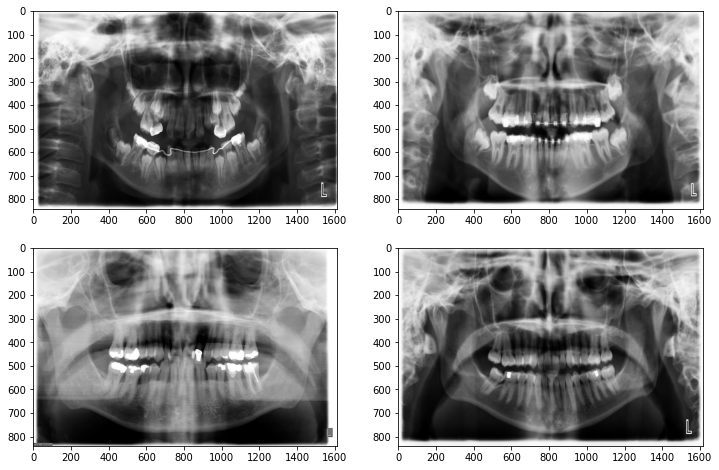

In [ ]:
# Display original radiographs
image_to_plot(sample_originals, 'gray')

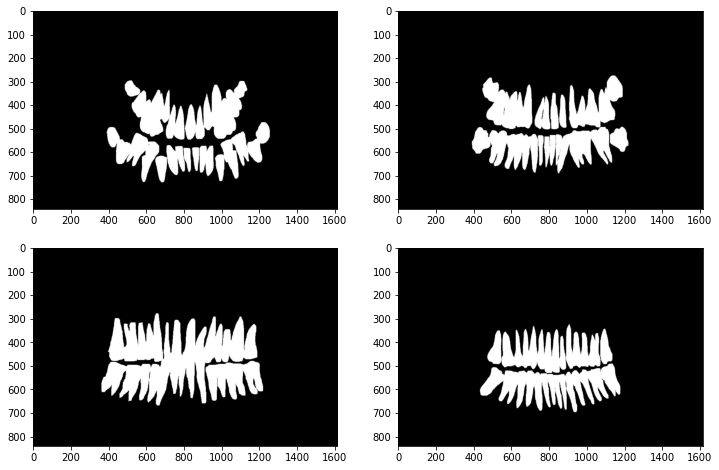

In [ ]:
# Display 4 teeth mask images (just the annotations)
image_to_plot(teeth, 'gray')

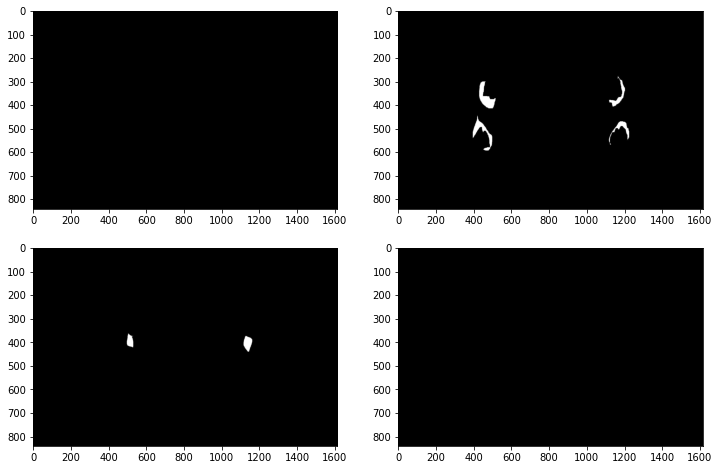

In [ ]:
# Display 4 abnormality mask images (just the annotations)
image_to_plot(abnormalities, 'gray')
# Note that some radiographs have no abnormalities

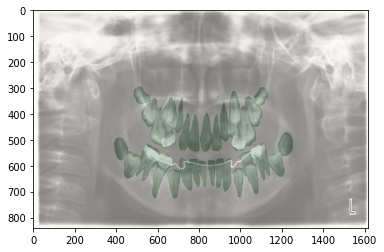

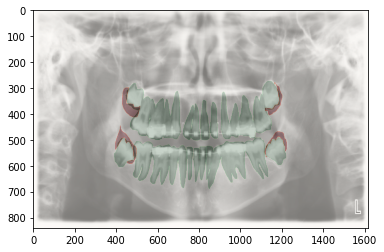

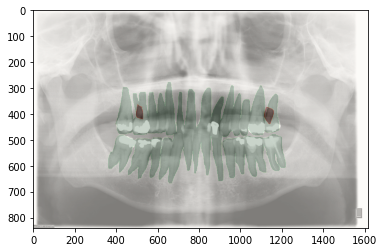

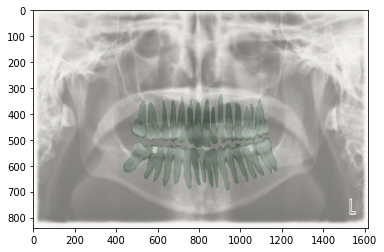

In [ ]:
# Overlay masks over original image
def mask_with_image(image, mask1, mask2):
  files = [image, mask1, mask2]
  images = [plt.imread(i)[:,:,0] if plt.imread(i).ndim == 3 else plt.imread(i) for i in files]
  colors = ['gray', 'Greens', 'Reds']
  alpha = [1, 0.3, 0.3]
  for i in range(len(files)):
    plt.imshow(images[i], cmap=colors[i], alpha=alpha[i], aspect='auto')
  plt.show()

for i in range(len(teeth)):
  mask_with_image(sample_originals[i], teeth[i], abnormalities[i])


<a name="eda-preprocess"></a>
## More EDA and Preprocessing

In [ ]:
# Create lists for teeth and abnormality masks
abnormalities = sorted(glob.glob('abnormality_masks/*'))
teeth = sorted(glob.glob('teeth_masks/*'))

# Get all the image details for the original images and store in a dataframe
def image_info(image_list):
  imgs = [PIL.Image.open(i) for i in image_list]
  file_type = [i.format for i in imgs]
  file_size = [i.size for i in imgs]
  file_colors = [i.mode for i in imgs]
  # Convert to numpy array and take the sum of the array to determine if the image is blank
  file_nparray_sums = [np.sum(np.asarray(i)) for i in imgs]
  image_df = pd.DataFrame({'type': file_type, 'size': file_size, 
                          'colors': file_colors, 'np_sums': file_nparray_sums})
  return image_df
# Create df for each folder to further analyze the images
original_df = image_info(originals)
abnormality_df = image_info(abnormalities)
teeth_df = image_info(teeth)

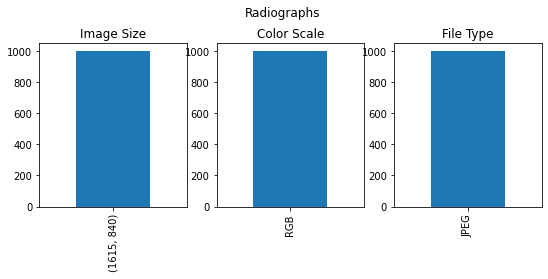

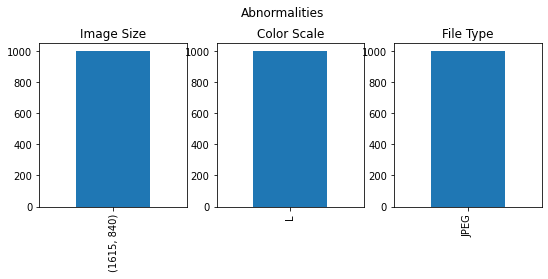

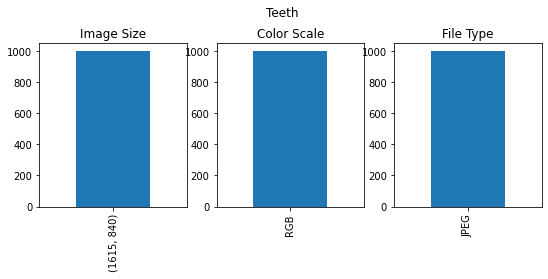

In [ ]:
# Plot info from each df
def plot_info(df, df_name):
  fig, axes = plt.subplots(1, 3, figsize=(9,3))
  fig.suptitle(df_name, y = 1.05)
  df['size'].value_counts().plot(kind='bar', ax=axes[0], title='Image Size')
  df['colors'].value_counts().plot(kind='bar', ax=axes[1], title='Color Scale')
  df['type'].value_counts().plot(kind='bar', ax=axes[2], title='File Type')
plot_info(original_df, 'Radiographs')
plot_info(abnormality_df, 'Abnormalities')
plot_info(teeth_df, 'Teeth')

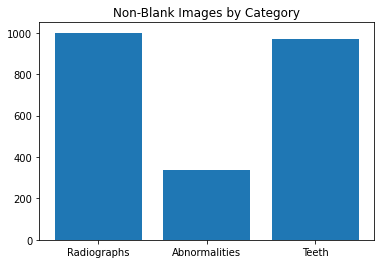

In [ ]:
# Compare count of images that are not blank
df_names = ['Radiographs', 'Abnormalities', 'Teeth']
df_counts = [np.count_nonzero(original_df['np_sums']), np.count_nonzero(abnormality_df['np_sums']), np.count_nonzero(teeth_df['np_sums'])]
plt.bar(df_names, df_counts)
plt.title('Non-Blank Images by Category')
plt.show()
# Only a little under 400 images actually have abnormalities to train on

In [ ]:
# Resize all images to 256x256
def resize_images(image_list):
  imgs = [PIL.Image.open(i) for i in image_list]
  new_imgs = [i.resize((256, 256)) for i in imgs]
  return new_imgs
# Apply resize function
resized_original = resize_images(originals)
resized_abnormalities = resize_images(abnormalities)
resized_teeth = resize_images(teeth)
# Convert teeth images to grayscale
resized_teeth = [i.convert('L') for i in resized_teeth]

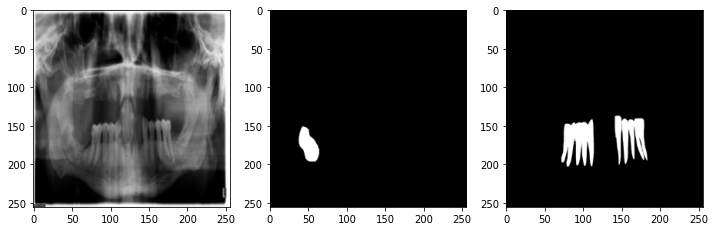

In [ ]:
random.seed(27)
# Print sample of resized images
fig, axes = plt.subplots(1, 3, figsize=(12, 8))
axes[0].imshow(resized_original[3], cmap='gray')
axes[1].imshow(resized_abnormalities[3], cmap='gray')
axes[2].imshow(resized_teeth[3], cmap='gray')

In [ ]:
# Save new images to individual folders
def save_cleaned_imgs(cleaned_img_list, dir_name):
  if os.path.exists(dir_name) and os.path.isdir(dir_name):
    shutil.rmtree(dir_name)
  os.mkdir(dir_name)
  for i in range(0, len(cleaned_img_list)):
    cleaned_img_list[i].save(dir_name + f'{i+1}.jpeg')

save_cleaned_imgs(resized_original, 'cleaned_original/')
save_cleaned_imgs(resized_abnormalities, 'cleaned_abnormalities/')
save_cleaned_imgs(resized_teeth, 'cleaned_teeth/')

In [ ]:
# Save folders to S3
def new_s3_folder(dir_name):
  s3_client = S3Client(aws_access_key_id=os.getenv('AWS_ACCESS_KEY'), aws_secret_access_key=os.getenv('AWS_SECRET_KEY'))
  s3_path = s3_client.S3Path('s3://ads-599-capstone-data/ads-599-team7').mkdir(dir_name)
  s3_path = s3_client.S3Path('s3://ads-599-capstone-data/ads-599-team7/' + dir_name).upload_from(dir_name)

new_s3_folder('cleaned_original')
new_s3_folder('cleaned_abnormalities')
new_s3_folder('cleaned_teeth')

In [ ]:
# Train-test-valid split of data
def train_valid_test(dir_name):
  clean_data = sorted(glob.glob(dir_name + '/*'))
  train, test = train_test_split(clean_data, test_size=0.1, random_state=27)
  # Train test split again to obtain validation set
  train, val = train_test_split(train, test_size=0.1, random_state=27)
  # Load all images in each set and convert to arrays
  train = [np.asarray(PIL.Image.open(i)) for i in train]
  val = [np.asarray(PIL.Image.open(i)) for i in val]
  test = [np.asarray(PIL.Image.open(i)) for i in test]
  return train, val, test

train_orig, val_orig, test_orig = train_valid_test('cleaned_original')
train_teeth, val_teeth, test_teeth = train_valid_test('cleaned_teeth')
train_ab, val_ab, test_ab = train_valid_test('cleaned_abnormalities')

[286, 22, 31]


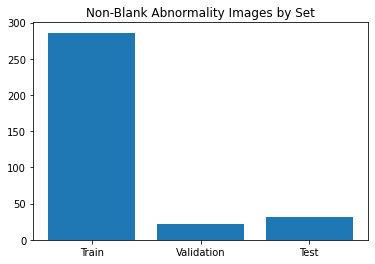

In [ ]:
# Check that abnormality masks are evenly distributed throughout train, val, and test sets
def count_array(list):
  return [np.sum(i) for i in list]
df_names = ['Train', 'Validation', 'Test']
df_counts = [np.count_nonzero(count_array(train_ab)), np.count_nonzero(count_array(val_ab)), np.count_nonzero(count_array(test_ab))]
plt.bar(df_names, df_counts)
plt.title('Non-Blank Abnormality Images by Set')
print(df_counts)
# Non-blank abnormality masks are correctly distributed